In [ ]:
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(data.table)
    library(Seurat)
    library(dplyr)
    library(tidyr)
    library(purrr)
    library(rlog)
    library(tibble)
    library(stringr)
    library(dittoSeq)
    library(patchwork)
    library(future)
    library(HGNChelper)
    plan("multiprocess", workers = 8)
    options(future.globals.maxSize = 1000 * 1024^5)
    options(stringsAsFactors = FALSE)
    set.seed(123)
})

Warning message:
“Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”


In [ ]:
gbm_mapped <- readRDS('data/mapped_Ruiz2021_to_core_GBmap.rds')

### Subsetting TILs

In [ ]:
tils <- subset(gbm_mapped, subset = predicted.high_hierarchy == 'CD/CD8')
tils

An object of class Seurat 
27102 features across 359 samples within 1 assay 
Active assay: RNA (27102 features, 2000 variable features)
 4 dimensional reductions calculated: mnn, pca, umap, mca

In [ ]:
# Identification of highly variable features (feature selection)
tils <- NormalizeData(tils, normalization.method = "LogNormalize", scale.factor = 10000)
tils <- FindVariableFeatures(tils, selection.method = "vst", nfeatures = 2000)
# Scaling the data
all.genes <- rownames(tils)
tils <- ScaleData(tils, features = all.genes)
# Perform linear dimensional reduction
tils <- RunPCA(tils, features = VariableFeatures(object = tils))

### Run MNN

In [ ]:
tils <- SeuratWrappers::RunFastMNN(object.list = SplitObject(tils, split.by = "orig.ident"))

In [ ]:
tils <- tils %>% 
    RunUMAP(reduction = "mnn", dims = 1:15) %>% 
    FindNeighbors(reduction = "mnn", dims = 1:15) %>% 
    FindClusters(resolution = 1) %>% 
    identity()

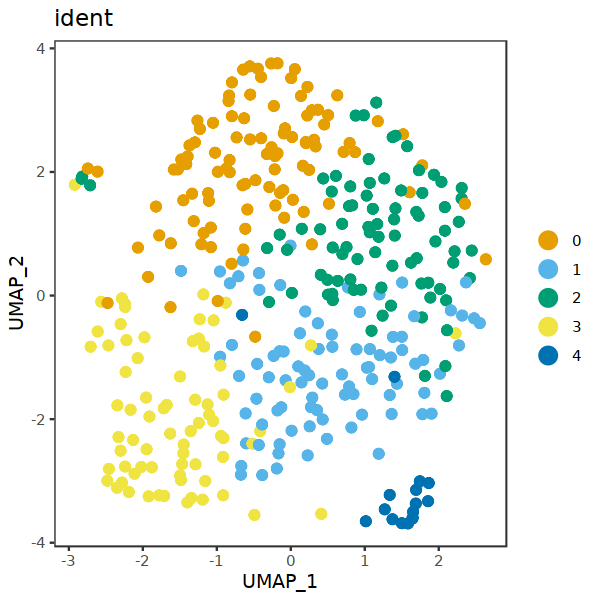

In [ ]:
options(repr.plot.height = 5, repr.plot.width = 5)
dittoDimPlot(tils, size = 3,
             reduction.use = "umap", var = "ident", 
             do.raster = TRUE)

In [ ]:
markers <- FindAllMarkers(tils, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4



In [ ]:
tils@misc <- markers
saveRDS(tils, '/data/subset_tils_Ruiz2021_dataset.rds')